In [30]:
# Importamos paquetes
# Cargamos paquetes necesarios

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torchvision import datasets, transforms

#helper was developed by Udacity under MIT license
import helper

In [31]:
# Hiper-parámetros

batch_size = 64

In [32]:
# Definimos una transformación de los datos
transform = transforms.Compose([transforms.Resize(32), # escalar a 32
                                transforms.ToTensor(), # convertir a tensores
                                transforms.Normalize([0.5], [0.5])]) #normalizar a media y desv std

# Descargamos el conjunto de entrenamiento y cargamos mediante un dataLoader
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

# Descargamos el conjunto de validación
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

# Imprimir información estadística del conjunto de datos
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

# Nombrar las clases de acuerdo al índice que tienen
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Train data, number of images:  60000
Test data, number of images:  10000


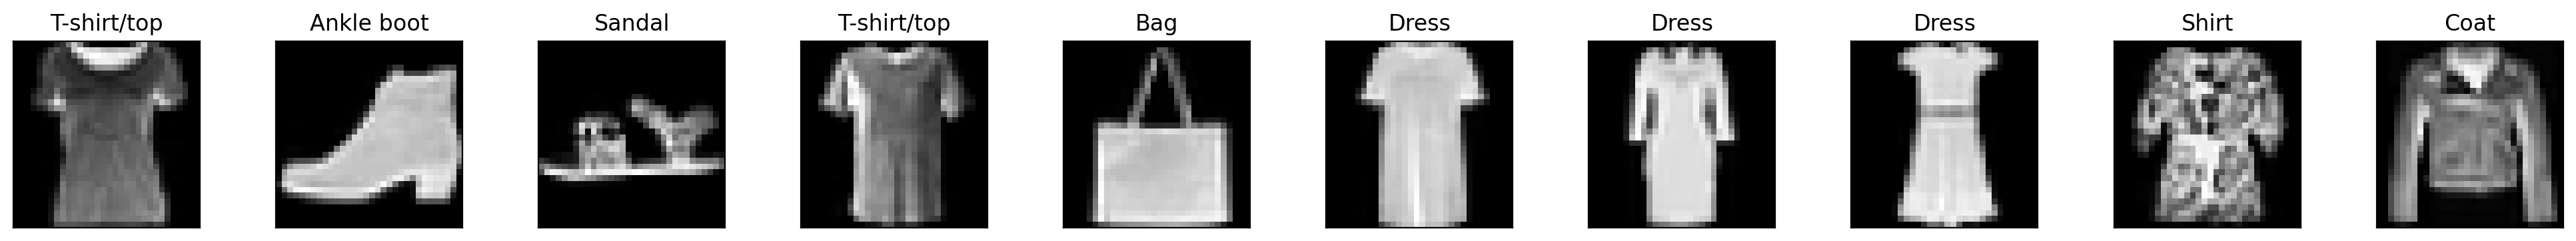

In [33]:
# Obtener un lote de ejemplos
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

display_size = 10

# Graficar los ejemplos junto a las clases que le corresponden
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [34]:
# Implementación de LeNet5
class LeNet5(nn.Module):
    def __init__(self, n_clases):
        '''
        Construimos la estructura de LeNet5
        
        '''
        super(LeNet5, self).__init__()
        
        # De acuerdo al artículo de LeCun La primera capa está compuesta por 6 kernels de 5x5
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 canal de entrada 6 feature maps de salida, kernels de 5x5
        
        # Después tenemos una capa maxpooling
        # kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(2,2)
        
        # Agregamos otra capa convolucional con 16 kernels de 5 x 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Maxpooling
        self.pool2 = nn.MaxPool2d(2,2)

        # Agregamos una ultima capa convolucional con 120 kernels de 5 x 5
        self.conv3 = nn.Conv2d(16, 120, 5)
        
        
        # Capas totalmente conectadas
        self.fc2 = nn.Linear(120,84) 
        self.relu2=nn.ReLU()
        self.fc3 = nn.Linear(84,len(classes) )
    
    def forward(self, x):
        '''
        Definimos el pase frontal (forward pass)
        '''
        # Agregamos los ReLUs y max pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))

        # prep for linear layer by flattening the feature maps into feature vectors
        x = x.view(x.size(0), -1)
        # capas lineales
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        
        # regresamos el resultado de pasar por softmax
        return F.log_softmax(x, dim=1)

In [35]:
# Instanciar la red
model = LeNet5(10)
# Definir la función de costo (critetio de optimización)
criterion = nn.NLLLoss()
# Instanciar optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Información de la red
model

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [37]:
# Implementamos una función de evaluación
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        #images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [38]:
from torch.autograd import Variable

# Antes del descenso por gradiente y el entrenamiento 
# verificaremos que la red está bien implementada a través verificar la exactitud que tiene sin haber sido entrenada.

correct = 0
total = 0

# Iterate through test dataset
for images, labels in testloader:
    
    # warp input images in a Variable wrapper
    images = Variable(images)

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = model(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct.numpy() / total

# print it out!
print('Porcentaje de exactitud antes de entrenar: ', accuracy)

Porcentaje de exactitud antes de entrenar:  9.73


In [39]:
from torch.autograd import Variable

# Hiperparámetros

epochs = 2
steps = 0
running_loss = 0
print_every = 40


# Descenso por gradiente
for e in range(epochs):
    # Cambiamos a modo entrenamiento
    model.train()
    
    for images, labels in trainloader:
        steps += 1
        
        # Aplanar imágenes a un vector de 784 elementos
        # images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # wrap them in a torch Variable
        images, labels = Variable(images), Variable(labels)       
        
        output = model(images)
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Cambiamos a modo de evaluación
            model.eval()
            
            # Apagamos los gradientes, reduce memoria y cálculos
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/2..  Training Loss: 1.665..  Test Loss: 0.969..  Test Accuracy: 0.647
Epoch: 1/2..  Training Loss: 0.849..  Test Loss: 0.777..  Test Accuracy: 0.702
Epoch: 1/2..  Training Loss: 0.717..  Test Loss: 0.739..  Test Accuracy: 0.714
Epoch: 1/2..  Training Loss: 0.697..  Test Loss: 0.671..  Test Accuracy: 0.731
Epoch: 1/2..  Training Loss: 0.634..  Test Loss: 0.645..  Test Accuracy: 0.746
Epoch: 1/2..  Training Loss: 0.603..  Test Loss: 0.615..  Test Accuracy: 0.759
Epoch: 1/2..  Training Loss: 0.601..  Test Loss: 0.607..  Test Accuracy: 0.769
Epoch: 1/2..  Training Loss: 0.583..  Test Loss: 0.575..  Test Accuracy: 0.780
Epoch: 1/2..  Training Loss: 0.582..  Test Loss: 0.594..  Test Accuracy: 0.764
Epoch: 1/2..  Training Loss: 0.584..  Test Loss: 0.545..  Test Accuracy: 0.799
Epoch: 1/2..  Training Loss: 0.540..  Test Loss: 0.534..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.526..  Test Loss: 0.576..  Test Accuracy: 0.783
Epoch: 1/2..  Training Loss: 0.479..  Test Loss: 0.5

<ipython-input-40-b524a349370c>:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  preds = np.squeeze(model(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].numpy())


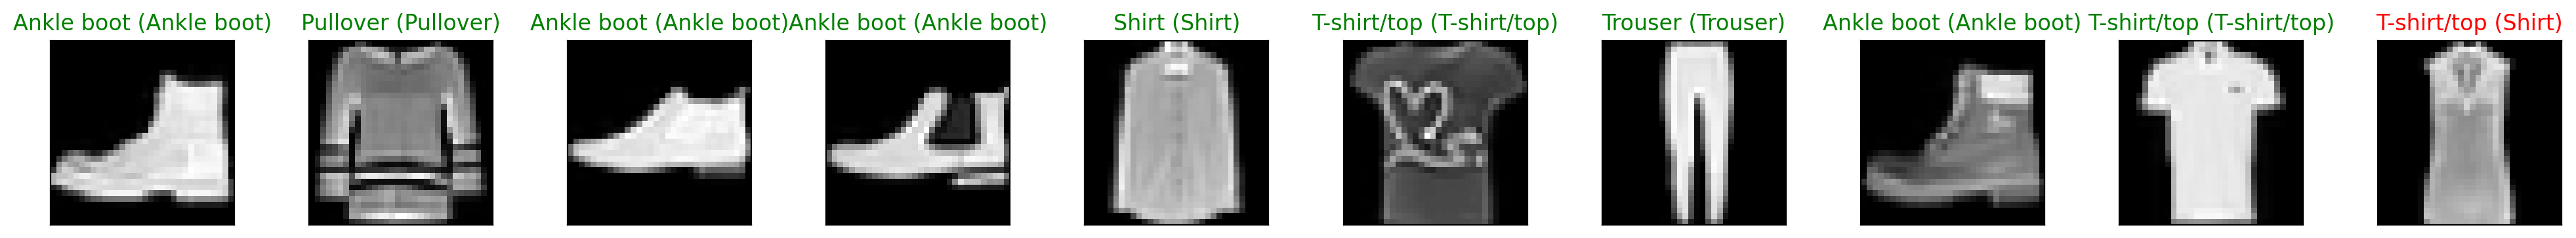

In [40]:
# obtain one batch of test images
display_size = 10

dataiter = iter(testloader)
images, labels = next(dataiter)
# get predictions
preds = np.squeeze(model(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))